# Running and Plotting Coeval Cubes

The aim of this tutorial is to introduce you to how `21cmFAST` does the most basic operations: producing single coeval cubes, and visually verifying them. It is a great place to get started with `21cmFAST`.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
# We change the default level of the logger so that
# we can see what's happening with caching.
import logging, sys, os
logger = logging.getLogger('21cmFAST')
logger.setLevel(logging.INFO)

import py21cmfast as p21c

# For plotting the cubes, we use the plotting submodule:
from py21cmfast import plotting

# For interacting with the cache
from py21cmfast import cache_tools



In [2]:
print(f"Using 21cmFAST version {p21c.__version__}")

Using 21cmFAST version 3.0.2


Clear the cache so that we get the same results for the notebook every time (don't worry about this for now). Also, set the default output directory to `_cache/`:

In [3]:
if not os.path.exists('_cache'):
    os.mkdir('_cache')
    
p21c.config['direc'] = '_cache'
cache_tools.clear_cache(direc="_cache")

2020-10-02 09:51:10,651 | INFO | Removed 0 files from cache.


## Basic Usage

The simplest (and typically most efficient) way to produce a coeval cube is simply to use the `run_coeval` method. This consistently performs all steps of the calculation, re-using any data that it can without re-computation or increased memory overhead.

In [4]:
coeval8, coeval9, coeval10 = p21c.run_coeval(
    redshift = [8.0, 9.0, 10.0],
    user_params = {"HII_DIM": 100, "BOX_LEN": 100, "USE_INTERPOLATION_TABLES": True},
    cosmo_params = p21c.CosmoParams(SIGMA_8=0.8),
    astro_params = p21c.AstroParams({"HII_EFF_FACTOR":20.0}),
    random_seed=12345
)

There are a number of possible inputs for `run_coeval`, which you can check out either in the [API reference](../reference/py21cmfast.html) or by calling `help(p21c.run_coeval)`. Notably, the `redshift` must be given: it can be a single number, or a list of numbers, defining the redshift at which the output coeval cubes will be defined. 

Other params we've given here are `user_params`, `cosmo_params` and `astro_params`. These are all used for defining input parameters into the backend C code (there's also another possible input of this kind; `flag_options`). These can be given either as a dictionary (as `user_params` has been), or directly as a relevant object (like `cosmo_params` and `astro_params`). If creating the object directly, the parameters can be passed individually or via a single dictionary. So there's a lot of flexibility there! Nevertheless we *encourage* you to use the basic dictionary. The other ways of passing the information are there so we can use pre-defined objects later on. For more information about these "input structs", see the [API docs](../reference/_autosummary/py21cmfast.inputs.html).

We've also given a `direc` option: this is the directory in which to search for cached data (and also where cached data should be written). Throughout this notebook we're going to set this directly to the `_cache` folder, which allows us to manage it directly. By default, the cache location is set in the global configuration in `~/.21cmfast/config.yml`. You'll learn more about caching further on in this tutorial. 

Finally, we've given a random seed. This sets all the random phases for the simulation, and ensures that we can exactly reproduce the same results on every run. 

The output of `run_coeval` is a list of `Coeval` instances, one for each input redshift (it's just a single object if a single redshift was passed, not a list). They store *everything* related to that simulation, so that it can be completely compared to other simulations. 

For example, the input parameters:

In [5]:
print("Random Seed: ", coeval8.random_seed)
print("Redshift: ", coeval8.redshift)
print(coeval8.user_params)

Random Seed:  12345
Redshift:  8.0
UserParams(BOX_LEN:100, DIM:300, HII_DIM:100, HMF:1, POWER_SPECTRUM:0, USE_FFTW_WISDOM:False, USE_RELATIVE_VELOCITIES:False)


This is where the utility of being able to pass a *class instance* for the parameters arises: we could run another iteration of coeval cubes, with the same user parameters, simply by doing `p21c.run_coeval(user_params=coeval8.user_params, ...)`.

Also in the `Coeval` instance are the various outputs from the different steps of the computation. You'll see more about what these steps are further on in the tutorial. But for now, we show that various boxes are available:

In [6]:
print(coeval8.hires_density.shape)
print(coeval8.brightness_temp.shape)

(300, 300, 300)
(100, 100, 100)


Along with these, full instances of the output from each step are available as attributes that end with "struct". These instances themselves contain the `numpy` arrays of the data cubes, and some other attributes that make them easier to work with:

In [7]:
coeval8.brightness_temp_struct.global_Tb

17.622644

By default, each of the components of the cube are cached to disk (in our `_cache/` folder) as we run it. However, the `Coeval` cube itself is _not_ written to disk by default. Writing it to disk incurs some redundancy, since that data probably already exists in the cache directory in seperate files.  

Let's save to disk. The save method by default writes in the current directory (not the cache!):

In [8]:
filename = coeval8.save(direc='_cache')

The filename of the saved file is returned:

In [9]:
print(os.path.basename(filename))

Coeval_z8.0_a3c7dea665420ae9c872ba2fab1b3d7d_r12345.h5


Such files can be read in:

In [10]:
new_coeval8 = p21c.Coeval.read(filename, direc='.')

Some convenient plotting functions exist in the `plotting` module. These can work directly on `Coeval` objects, or any of the output structs (as we'll see further on in the tutorial). By default the `coeval_sliceplot` function will plot the `brightness_temp`, using the standard traditional colormap:

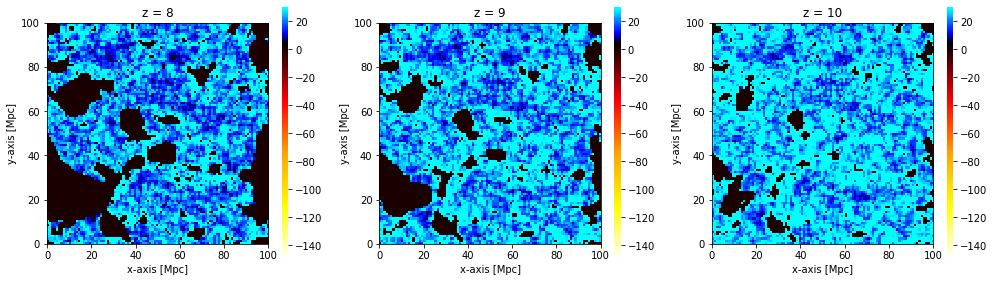

In [11]:
fig, ax = plt.subplots(1,3, figsize=(14,4))
for i, (coeval, redshift) in enumerate(zip([coeval8, coeval9, coeval10], [8,9,10])):
    plotting.coeval_sliceplot(coeval, ax=ax[i], fig=fig);
    plt.title("z = %s"%redshift)
plt.tight_layout()

Any 3D field can be plotted, by setting the `kind` argument. For example, we could alternatively have plotted the dark matter density cubes perturbed to each redshift:

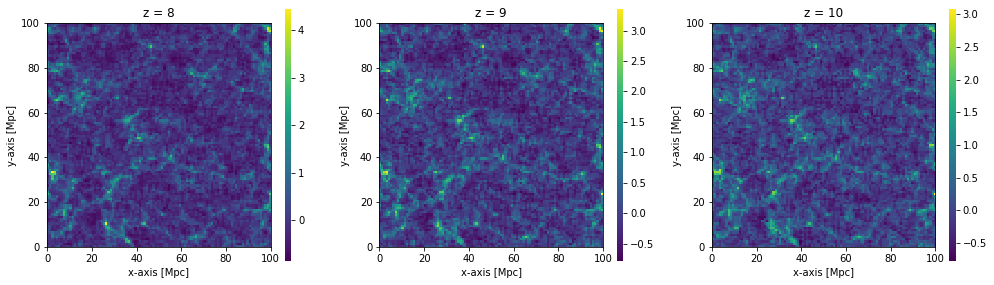

In [12]:
fig, ax = plt.subplots(1,3, figsize=(14,4))
for i, (coeval, redshift) in enumerate(zip([coeval8, coeval9, coeval10], [8,9,10])):
    plotting.coeval_sliceplot(coeval, kind='density', ax=ax[i], fig=fig);
    plt.title("z = %s"%redshift)
plt.tight_layout()

To see more options for the plotting routines, see the [API Documentation](../reference/_autosummary/py21cmfast.plotting.html).

`Coeval` instances are not cached themselves -- they are containers for data that is itself cached (i.e. each of the `_struct` attributes of `Coeval`). See the [api docs](../reference/_autosummary/py21cmfast.outputs.html) for more detailed information on these. 

You can see the filename of each of these structs (or the filename it would have if it were cached -- you can opt to *not* write out any given dataset):

In [13]:
coeval8.init_struct.filename

'InitialConditions_6f0eb48c62c36acef23416d5d0fbcf3b_r12345.h5'

You can also write the struct anywhere you'd like on the filesystem. This will not be able to be automatically used as a cache, but it could be useful for sharing files with colleagues.

In [14]:
coeval8.init_struct.save(fname='my_init_struct.h5')

This brief example covers most of the basic usage of `21cmFAST` (at least with `Coeval` objects -- there are also `Lightcone` objects for which there is a separate tutorial). 

For the rest of the tutorial, we'll cover a more advanced usage, in which each step of the calculation is done independently.

## Advanced Step-by-Step Usage

Most users most of the time will want to use the high-level `run_coeval` function from the previous section. However, there are several independent steps when computing the brightness temperature field, and these can be performed one-by-one, adding any other effects between them if desired. This means that the new `21cmFAST` is much more flexible. In this section, we'll go through in more detail how to use the lower-level methods.

Each step in the chain will receive a number of input-parameter classes which define how the calculation should run. These are the `user_params`, `cosmo_params`, `astro_params` and `flag_options` that we saw in the previous section.

Conversely, each step is performed by running a function which will return a single object. Every major function returns an object of the same fundamental class (an ``OutputStruct``) which has various methods for reading/writing the data, and ensuring that it's in the right state to receive/pass to and from C.
These are the objects stored as `init_box_struct` etc. in the `Coeval` class.

As we move through each step, we'll outline some extra details, hints and tips about using these inputs and outputs.

### Initial Conditions

The first step is to get the initial conditions, which defines the *cosmological* density field before any redshift evolution is applied.

In [15]:
initial_conditions = p21c.initial_conditions(
    user_params = {"HII_DIM": 100, "BOX_LEN": 100},
    cosmo_params = p21c.CosmoParams(SIGMA_8=0.8),
    random_seed=54321
)

We've already come across all these parameters as inputs to the `run_coeval` function. Indeed, most of the steps have very similar interfaces, and are able to take a random seed and parameters for where to look for the cache. We use a different seed than in the previous section so that all our boxes are "fresh" (we'll show how the caching works in a later section).

These initial conditions have 100 cells per side, and a box length of 100 Mpc. Note again that they can either be passed as a dictionary containing the input parameters, or an actual instance of the class. While the former is the suggested way, one benefit of the latter is that it can be queried for the relevant parameters (by using ``help`` or a post-fixed ``?``), or even queried for defaults:

In [16]:
p21c.CosmoParams._defaults_

{'SIGMA_8': 0.8102,
 'hlittle': 0.6766,
 'OMm': 0.30964144154550644,
 'OMb': 0.04897468161869667,
 'POWER_INDEX': 0.9665}

(these defaults correspond to the Planck15 cosmology contained in Astropy).

So what is in the ``initial_conditions`` object? It is what we call an ``OutputStruct``, and we have seen it before, as the `init_box_struct` attribute of `Coeval`. It contains a number of arrays specifying the density and velocity fields of our initial conditions, as well as the defining parameters. For example, we can easily show the cosmology parameters that are used (note the non-default $\sigma_8$ that we passed):

In [17]:
initial_conditions.cosmo_params

CosmoParams(OMb:0.04897468161869667, OMm:0.30964144154550644, POWER_INDEX:0.9665, SIGMA_8:0.8, hlittle:0.6766)

A handy tip is that the ``CosmoParams`` class also has a reference to a corresponding Astropy cosmology, which can be used more broadly:

In [18]:
initial_conditions.cosmo_params.cosmo

FlatLambdaCDM(name="Planck15", H0=67.7 km / (Mpc s), Om0=0.31, Tcmb0=2.725 K, Neff=3.05, m_nu=[0.   0.   0.06] eV, Ob0=0.049)

Merely printing the initial conditions object gives a useful representation of its dependent parameters:

In [19]:
print(initial_conditions)

InitialConditions(UserParams(BOX_LEN:100, DIM:300, HII_DIM:100, HMF:1, POWER_SPECTRUM:0, USE_FFTW_WISDOM:False, USE_RELATIVE_VELOCITIES:False);
	CosmoParams(OMb:0.04897468161869667, OMm:0.30964144154550644, POWER_INDEX:0.9665, SIGMA_8:0.8, hlittle:0.6766);
	random_seed:54321)


(side-note: the string representation of the object is used to uniquely define it in order to save it to the cache... which we'll explore soon!).

To see which arrays are defined in the object, access the ``fieldnames`` (this is true for *all* `OutputStruct` objects):

In [20]:
initial_conditions.fieldnames

['lowres_density',
 'lowres_vx',
 'lowres_vy',
 'lowres_vz',
 'lowres_vx_2LPT',
 'lowres_vy_2LPT',
 'lowres_vz_2LPT',
 'hires_density',
 'lowres_vcb',
 'hires_vcb']

The `coeval_sliceplot` function also works on `OutputStruct` objects (as well as the `Coeval` object as we've already seen). It takes the object, and a specific field name. By default, the field it plots is the _first_ field in `fieldnames` (for any `OutputStruct`).

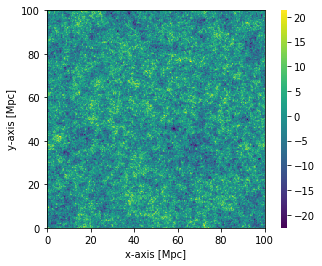

In [21]:
plotting.coeval_sliceplot(initial_conditions, "hires_density");

### Perturbed Field

After obtaining the initial conditions, we need to *perturb* the field to a given redshift (i.e. the redshift we care about). This step clearly requires the results of the previous step, which we can easily just pass in. Let's do that:

In [22]:
perturbed_field = p21c.perturb_field(
    redshift = 8.0,
    init_boxes = initial_conditions
)

Note that we didn't need to pass in any input parameters, because they are all contained in the `initial_conditions` object itself. The random seed is also taken from this object.

Again, the output is an `OutputStruct`, so we can view its fields:

In [23]:
perturbed_field.fieldnames

['density', 'velocity']

This time, it has only density and velocity (the velocity direction is chosen without loss of generality). Let's view the perturbed density field:

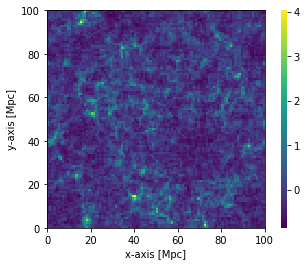

In [24]:
plotting.coeval_sliceplot(perturbed_field, "density");

It is clear here that the density used is the *low*-res density, but the overall structure of the field looks very similar.

### Ionization Field

Next, we need to ionize the box. This is where things get a little more tricky. In the simplest case (which, let's be clear, is what we're going to do here) the ionization occurs at the *saturated limit*, which means we can safely ignore the contribution of the spin temperature. This means we can directly calculate the ionization on the density/velocity fields that we already have. A few more parameters are needed here, and so two more "input parameter dictionaries" are available, ``astro_params`` and ``flag_options``. Again, a reminder that their parameters can be viewed by using eg. `help(p21c.AstroParams)`, or by looking at the [API docs](../reference/_autosummary/py21cmfast.inputs.html).

For now, let's leave everything as default. In that case, we can just do:

In [25]:
ionized_field = p21c.ionize_box(
    perturbed_field = perturbed_field
)

2020-02-29 15:10:43,902 | INFO | Existing init_boxes found and read in (seed=54321).


That was easy! All the information required by ``ionize_box`` was given directly by the ``perturbed_field`` object. If we had _also_ passed a redshift explicitly, this redshift would be checked against that from the ``perturbed_field`` and an error raised if they were incompatible:

Let's see the fieldnames:

In [26]:
ionized_field.fieldnames

['first_box', 'xH_box', 'Gamma12_box', 'z_re_box', 'dNrec_box']

Here the ``first_box`` field is actually just a flag to tell the C code whether this has been *evolved* or not. Here, it hasn't been, it's the "first box" of an evolutionary chain. Let's plot the neutral fraction:

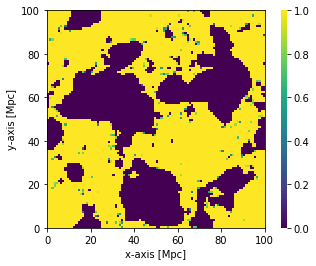

In [27]:
plotting.coeval_sliceplot(ionized_field, "xH_box");

### Brightness Temperature

Now we can use what we have to get the brightness temperature:

In [28]:
brightness_temp = p21c.brightness_temperature(ionized_box=ionized_field, perturbed_field=perturbed_field)

This has only a single field, ``brightness_temp``:

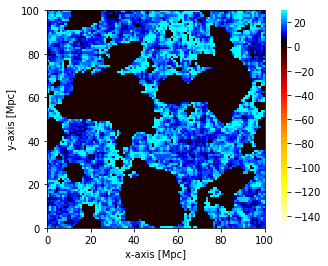

In [29]:
plotting.coeval_sliceplot(brightness_temp);

### The Problem

And there you have it -- you've computed each of the four steps (there's actually another, `spin_temperature`, that you require if you don't assume the saturated limit) individually. 

However, some problems quickly arise. What if you want the `perturb_field`, but don't care about the initial conditions? We know how to get the full `Coeval` object in one go, but it would seem that the sub-boxes have to _each_ be computed as the input to the next. 

A perhaps more interesting problem is that some quantities require *evolution*: i.e. a whole bunch of simulations at a string of redshifts must be performed in order to obtain the current redshift. This is true when not in the saturated limit, for example. That means you'd have to manually compute each redshift in turn, and pass it to the computation at the next redshift. While this is definitely possible, it becomes difficult to set up manually when all you care about is the box at the final redshift.

`py21cmfast` solves this by making each of the functions recursive: if `perturb_field` is not passed the `init_boxes` that it needs, it will go and compute them, based on the parameters that you've passed it. If the previous `spin_temp` box required for the current redshift is not passed -- it will be computed (and if it doesn't have a previous `spin_temp` *it* will be computed, and so on).

That's all good, but what if you now want to compute another `perturb_field`, with the same fundamental parameters (but at a different redshift)? Since you didn't ever see the `init_boxes`, they'll have to be computed all over again. That's where the automatic caching comes in, which is where we turn now...

## Using the Automatic Cache

To solve all this, ``21cmFAST`` uses an on-disk caching mechanism, where all boxes are saved in HDF5 format in a default location. The cache allows for reading in previously-calculated boxes automatically if they match the parameters that are input. The functions used at every step (in the previous section) will try to use a cached box instead of calculating a new one, unless its explicitly asked *not* to. 

Thus, we could do this:

2020-02-29 15:10:45,367 | INFO | Existing z=8.0 perturb_field boxes found and read in (seed=12345).


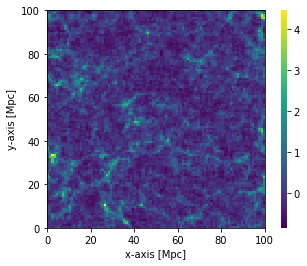

In [30]:
perturbed_field = p21c.perturb_field(
    redshift = 8.0,
    user_params = {"HII_DIM": 100, "BOX_LEN": 100},
    cosmo_params = p21c.CosmoParams(SIGMA_8=0.8),
)
plotting.coeval_sliceplot(perturbed_field, "density");

Note that here we pass exactly the same parameters as were used in the previous section. It gives a message that the full box was found in the cache and immediately returns. However, if we change the redshift:

2020-02-29 15:10:45,748 | INFO | Existing init_boxes found and read in (seed=12345).


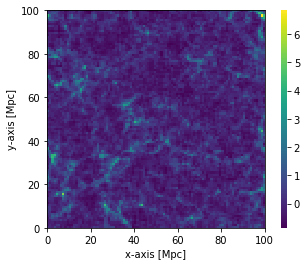

In [31]:
perturbed_field = p21c.perturb_field(
    redshift = 7.0,
    user_params = {"HII_DIM": 100, "BOX_LEN": 100},
    cosmo_params = p21c.CosmoParams(SIGMA_8=0.8),
)
plotting.coeval_sliceplot(perturbed_field, "density");

Now it finds the initial conditions, but it must compute the perturbed field at the new redshift. If we had changed the initial parameters as well, it would have to calculate everything:

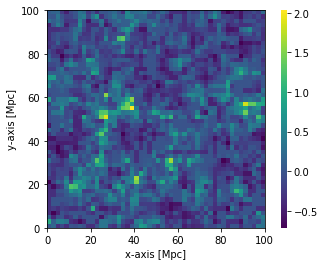

In [32]:
perturbed_field = p21c.perturb_field(
    redshift = 8.0,
    user_params = {"HII_DIM": 50, "BOX_LEN": 100},
    cosmo_params = p21c.CosmoParams(SIGMA_8=0.8),
)

plotting.coeval_sliceplot(perturbed_field, "density");

This shows that we don't need to perform the *previous* step to do any of the steps, they will be calculated automatically.

Now, let's get an ionized box, but this time we won't assume the saturated limit, so we need to use the spin temperature. We can do this directly in the ``ionize_box`` function, but let's do it explicitly. We will use the auto-generation of the initial conditions and perturbed field. However, the spin temperature is an *evolved* field, i.e. to compute the field at $z$, we need to know the field at $z+\Delta z$. This continues up to some redshift, labelled ``z_heat_max``, above which the spin temperature can be defined directly from the perturbed field. 

Thus, one option is to pass to the function a *previous* spin temperature box, to evolve to *this* redshift. However, we don't have a previous spin temperature box yet. Of course, the function itself will go and calculate that box if it's not given (or read it from cache if it's been calculated before!). When it tries to do that, it will go to the one before, and so on until it reaches ``z_heat_max``, at which point it will calculate it directly. 

To facilitate this recursive progression up the redshift ladder, there is a parameter, ``z_step_factor``, which is a multiplicate factor that determines the previous redshift at each step. 

We can also pass the dependent boxes explicitly, which provides the parameters necessary.

**WARNING: THIS IS THE MOST TIME-CONSUMING STEP OF THE CALCULATION!**

In [34]:
spin_temp = p21c.spin_temperature(
    perturbed_field = perturbed_field,
    zprime_step_factor=1.05,
)

2020-02-29 15:11:38,347 | INFO | Existing init_boxes found and read in (seed=521414794440).


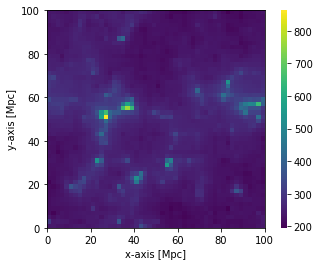

In [35]:
plotting.coeval_sliceplot(spin_temp, "Ts_box");

Let's note here that each of the functions accepts a few of the same arguments that modifies how the boxes are cached. There is a ``write`` argument, which if set to ``False``, will disable writing that box to cache (and it is passed through the recursive heirarchy). There is also ``regenerate``, which if ``True``, forces this box and all its predecessors to be re-calculated even if they exist in the cache. Then there is ``direc``, which we have seen before.

Finally note that by default, ``random_seed`` is set to ``None``. If this is the case, then any cached dataset matching all other parameters will be read in, and the ``random_seed`` will be set based on the file read in. If it is set to an integer number, then the cached dataset must also match the seed. If it is ``None``, and no matching dataset is found, a random seed will be autogenerated.

Now if we calculate the ionized box, ensuring that it uses the spin temperature, then it will also need to be evolved. However, due to the fact that we cached each of the spin temperature steps, these should be read in accordingly:

In [36]:
ionized_box = p21c.ionize_box(
    spin_temp = spin_temp,
    zprime_step_factor=1.05,
)

2020-02-29 15:12:55,794 | INFO | Existing init_boxes found and read in (seed=521414794440).
2020-02-29 15:12:55,814 | INFO | Existing z=34.2811622461279 perturb_field boxes found and read in (seed=521414794440).
2020-02-29 15:12:55,827 | INFO | Existing z=34.2811622461279 spin_temp boxes found and read in (seed=521414794440).
2020-02-29 15:12:55,865 | INFO | Existing z=32.60110690107419 perturb_field boxes found and read in (seed=521414794440).
2020-02-29 15:12:55,880 | INFO | Existing z=32.60110690107419 spin_temp boxes found and read in (seed=521414794440).
2020-02-29 15:12:55,906 | INFO | Existing z=31.00105419149923 perturb_field boxes found and read in (seed=521414794440).
2020-02-29 15:12:55,919 | INFO | Existing z=31.00105419149923 spin_temp boxes found and read in (seed=521414794440).
2020-02-29 15:12:55,948 | INFO | Existing z=29.4771944680945 perturb_field boxes found and read in (seed=521414794440).
2020-02-29 15:12:55,963 | INFO | Existing z=29.4771944680945 spin_temp boxes

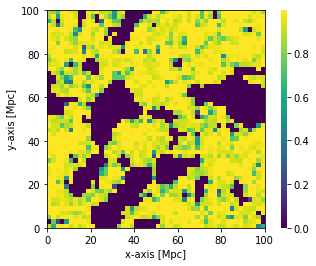

In [37]:
 plotting.coeval_sliceplot(ionized_box, "xH_box");

Great! So again, we can just get the brightness temp:

In [38]:
brightness_temp = p21c.brightness_temperature(
    ionized_box = ionized_box,
    perturbed_field = perturbed_field,
    spin_temp = spin_temp
)

Now lets plot our brightness temperature, which has been evolved from high redshift with spin temperature fluctuations:

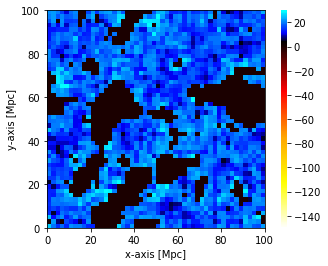

In [39]:
plotting.coeval_sliceplot(brightness_temp);

We can also check what the result would have been if we had limited the maximum redshift of heating. Note that this *recalculates* all previous spin temperature and ionized boxes, because they depend on both ``z_heat_max`` and ``zprime_step_factor``.

2020-02-29 15:13:08,824 | INFO | Existing init_boxes found and read in (seed=521414794440).
2020-02-29 15:13:08,840 | INFO | Existing z=19.62816486020931 perturb_field boxes found and read in (seed=521414794440).
2020-02-29 15:13:11,438 | INFO | Existing z=18.645871295437438 perturb_field boxes found and read in (seed=521414794440).
2020-02-29 15:13:11,447 | INFO | Existing z=19.62816486020931 spin_temp boxes found and read in (seed=521414794440).
2020-02-29 15:13:14,041 | INFO | Existing z=17.71035361470232 perturb_field boxes found and read in (seed=521414794440).
2020-02-29 15:13:14,050 | INFO | Existing z=18.645871295437438 spin_temp boxes found and read in (seed=521414794440).
2020-02-29 15:13:16,667 | INFO | Existing z=16.81938439495459 perturb_field boxes found and read in (seed=521414794440).
2020-02-29 15:13:16,675 | INFO | Existing z=17.71035361470232 spin_temp boxes found and read in (seed=521414794440).
2020-02-29 15:13:19,213 | INFO | Existing z=15.970842280909132 perturb_

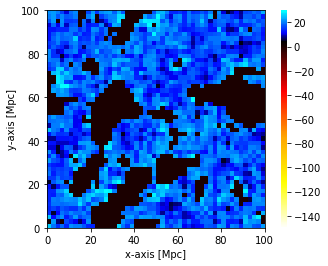

In [40]:
ionized_box = p21c.ionize_box(
    spin_temp = spin_temp,
    zprime_step_factor=1.05,
    z_heat_max = 20.0
)

brightness_temp = p21c.brightness_temperature(
    ionized_box = ionized_box,
    perturbed_field = perturbed_field,
    spin_temp = spin_temp
)

plotting.coeval_sliceplot(brightness_temp);

As we can see, it's very similar!